The optimization of share price prediction model based on support vector machine 사용

In [1]:
import json
import numpy as np
import pandas as pd

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
import regex as re
from nltk.corpus import stopwords

from nltk.sentiment.vader import SentimentIntensityAnalyzer
import datetime

from pandas_datareader import data as pdr
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.layers import Embedding, Dense, LSTM, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import optimizers
from keras import backend as K
import matplotlib.pyplot as plt

import datetime
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error 

C:\Users\default.DESKTOP-IT64657\anaconda3\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [21]:
def time_conversion(time):
    time = pd.Timestamp(time)
    return time

def svr_model_result(dir, stock, variable, window_size):
    #score data 뽑기
    score = pd.read_csv(dir)
    score.columns = ["Date", "Score", "class_3", "class_5"]
    score = score[["Date","class_3"]]
    
    #price data 뽑기
    price_data = yf.download([stock],start = '2017-01-01', end = "2022-05-01")
    price_data = price_data.reset_index()
    
    first_data = yf.download([stock],start = '2016-12-31', end = '2017-01-01')
    
    #Date를 datetime형식으로 변경
    score.Date = score.Date.apply(lambda x: time_conversion(x))
    
    #price data와 score data 결합
    price_data = pd.merge(price_data, score, how ="left",left_on='Date', right_on = "Date")[["Close","class_3"]]

    #뉴스가 없는 날은 즉, score가 없는 날은 중립의 의미로 0으로 처리
    price_data.class_3[price_data.class_3.isnull()]=0

    #전날 종가의 영향을 받으므로 전날 종가 변수를 생성
    price_data["before_close"] = 0
    price_data = price_data.reset_index(drop=True)
    for i in range(len(price_data)-1):
        price_data.before_close[i+1] = price_data.Close[i]
    
    price_data.before_close[0] = first_data["Close"][0]

    # minmaxscaler 사용
    price_data = pd.DataFrame(MinMaxScaler().fit_transform(price_data))
    price_data.columns = ["Close","class_3","before_close"]
    
    # train:test = 0.7:0.3으로 분류
    train_index = int(len(price_data)*0.7)

    train = price_data.iloc[0:train_index]
    test = price_data.iloc[train_index:len(price_data)]


    train_x = train[variable]
    train_y = train[["Close"]]

    test_x = test[variable]
    test_y = test[["Close"]]
    
    train_x = train_x.to_numpy().reshape(len(train_x),len(variable),1)
    train_y = train_y.to_numpy().reshape(len(train_y),1)
    test_x = test_x.to_numpy().reshape(len(test_x),len(variable),1)
    test_y = test_y.to_numpy().reshape(len(test_y),1)
    
    #window size에 맞게 데이터 설정
    x = np.zeros(shape=(len(train_x)-window_size+1,window_size*len(variable),1))
    for i in range(len(train_x)-window_size+1):
        x[i]=np.vstack((train_x[i:i+window_size]))

    y = train_y[window_size-1:len(train_y)]

    x_t = np.zeros(shape=(len(test_x)-window_size+1,window_size*len(variable),1))
    for i in range(len(test_x)-window_size+1):
        x_t[i]=np.vstack((test_x[i:i+window_size]))
    
    y_t = test_y[window_size-1:len(test_y)]
    
    x = x.reshape(len(x),window_size*len(variable))
    y = y.reshape(len(y),1)
    x_t = x_t.reshape(len(x_t),window_size*len(variable))
    y_t = y_t.reshape(len(y_t),1)
    
    # SVR model 생성
    model = SVR(kernel = 'rbf', C=102.2, gamma = 0.0625, epsilon= 0.01)
    model.fit(x, y)
    
    #예측값
    pred = np.reshape(model.predict(x_t),(len(model.predict(x_t)),1))
    
    #fig = plt.figure(figsize=(12,6))
    return (mean_squared_error(y_t, pred),np.sqrt(mean_squared_error(y_t, pred)))
    #return (mean_squared_error(y_t, pred),np.sqrt(mean_squared_error(y_t, pred))), plt.subplot(1, 2, 1), plt.plot(y_t),plt.plot(pred),plt.subplot(1, 2, 2), plt.plot(y_t[100:110]),plt.plot(pred[100:110])
    

In [3]:
dir = "C:/Users/default.DESKTOP-IT64657/Desktop/논문code/csv_data/price_data_score.csv"
stock = "^DJI"
variable = ["before_close"]

In [10]:
print(range(30))

range(0, 30)


In [22]:
import warnings
warnings.filterwarnings('ignore')
for i in range(1,31):
    print("---------------------------------"+str(i)+"---------------------------------")
    print(svr_model_result(dir, stock, variable, i))

---------------------------------1---------------------------------
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(0.000415265471286398, 0.020378063482244774)
---------------------------------2---------------------------------
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(0.0007878472475701453, 0.028068616773367108)
---------------------------------3---------------------------------
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(0.0013315238644013526, 0.036490051581237214)
---------------------------------4---------------------------------
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(0.0013889376070204103, 0.0372684532415

In [27]:
variable = ["before_close","class_3"]

In [28]:
import warnings
warnings.filterwarnings('ignore')
for i in range(1,31):
    print("---------------------------------"+str(i)+"---------------------------------")
    print(svr_model_result(dir, stock, variable, i))

---------------------------------1---------------------------------
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(0.0004998417228131187, 0.022357140309375856)
---------------------------------2---------------------------------
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(0.0009285338580242703, 0.030471853537720188)
---------------------------------3---------------------------------
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(0.0016744189509319996, 0.04091966459945633)
---------------------------------4---------------------------------
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(0.0016070828040923735, 0.0400884372867

## 1. price data, window size = 1

In [18]:
dir = "C:/Users/default.DESKTOP-IT64657/Desktop/논문code/csv_data/price_data_score.csv"
stock = "^DJI"
variable = ["before_close"]
window_size = 1

In [19]:
svr_model_result(dir, stock, variable, window_size)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


<ipython-input-15-f1b7e35e1bd8>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_data.before_close[i+1] = price_data.Close[i]
C:\Users\default.DESKTOP-IT64657\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


(0.000415265471286398, 0.020378063482244774)

<Figure size 864x432 with 0 Axes>

## 2. price data, window size = 4

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


<ipython-input-227-e093e32caf2a>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_data.before_close[i+1] = price_data.Close[i]
C:\Users\default.DESKTOP-IT64657\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


((0.0013889376070204103, 0.03726845324158772),
 <AxesSubplot:>,
 <AxesSubplot:>,
 [<matplotlib.lines.Line2D at 0x1ab25012250>])

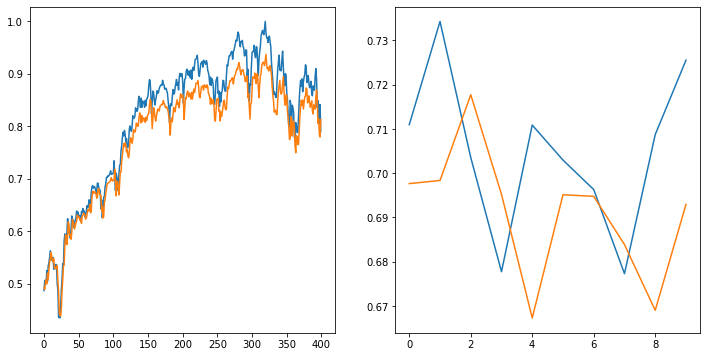

In [229]:
dir = "C:/Users/default.DESKTOP-IT64657/Desktop/논문code/csv_data/price_data_score.csv"
stock = "^DJI"
variable = ["before_close"]
window_size = 4

svr_model_result(dir, stock, variable, window_size)

## 3. price data+ score data, window size = 1

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


<ipython-input-235-31c7942fa1da>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_data.before_close[i+1] = price_data.Close[i]
C:\Users\default.DESKTOP-IT64657\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


((0.0004998417228131187, 0.022357140309375856),
 <AxesSubplot:>,
 <AxesSubplot:>,
 [<matplotlib.lines.Line2D at 0x1ab26574e20>])

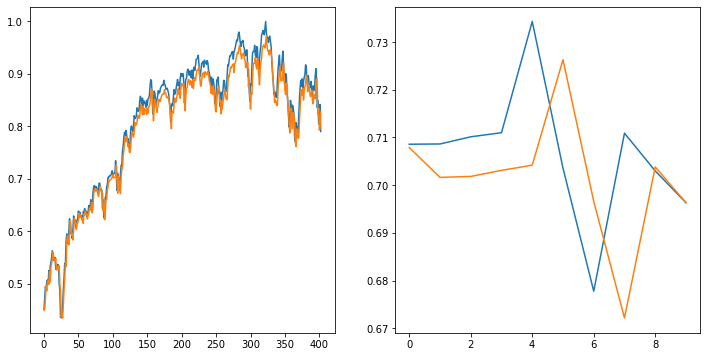

In [237]:
dir = "C:/Users/default.DESKTOP-IT64657/Desktop/논문code/csv_data/price_data_score.csv"
stock = "^DJI"
variable = ["before_close","class_3"]
window_size = 1

svr_model_result(dir, stock, variable, window_size)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


<ipython-input-235-31c7942fa1da>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_data.before_close[i+1] = price_data.Close[i]
C:\Users\default.DESKTOP-IT64657\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


((0.0016070828040923735, 0.04008843728673361),
 <AxesSubplot:>,
 <AxesSubplot:>,
 [<matplotlib.lines.Line2D at 0x1ab265c0c40>])

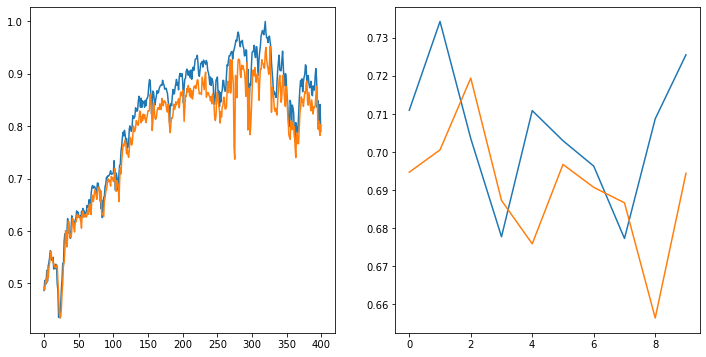

In [238]:
dir = "C:/Users/default.DESKTOP-IT64657/Desktop/논문code/csv_data/price_data_score.csv"
stock = "^DJI"
variable = ["before_close","class_3"]
window_size = 4

svr_model_result(dir, stock, variable, window_size)

#### def 전 code

In [ ]:
score = pd.read_csv(dir)
score.columns = ["Date", "Score", "class_3", "class_5"]

In [186]:
score = score[["Date","class_3"]]

In [187]:
price_data = yf.download(["^DJI"],start = '2017-01-01', end = "2022-05-01")
price_data = price_data.reset_index()

[*********************100%***********************]  1 of 1 completed


In [188]:
first_data = yf.download(["^DJI"],start = '2016-12-31', end = '2017-01-01')

[*********************100%***********************]  1 of 1 completed


In [191]:
score.Date

0      2017-01-03
1      2017-01-04
2      2017-01-05
3      2017-01-06
4      2017-01-09
          ...    
1309   2022-04-25
1310   2022-04-26
1311   2022-04-27
1312   2022-04-28
1313   2022-04-29
Name: Date, Length: 1314, dtype: datetime64[ns]

In [190]:
def time_conversion(time):
    time = pd.Timestamp(time)
    return time

score.Date = score.Date.apply(lambda x: time_conversion(x))

In [159]:
price_data = pd.merge(price_data, score, how ="left",left_on='Date', right_on = "Date")[["Close","Open","High","Low","Adj Close","class_3"]]
price_data.class_3[price_data.class_3.isnull()]=0
price_data["before_close"] = 0
price_data = price_data.reset_index(drop=True)
for i in range(len(price_data)-1):
    price_data.before_close[i+1] = price_data.Close[i]
    
price_data.before_close[0] = first_data["Close"][0]

for i in range(len(price_data)):
    price_data.High[len(price_data)-i] =price_data.High[len(price_data)-i-1]
    price_data.Open[len(price_data)-i] =price_data.Open[len(price_data)-i-1]
    price_data.Low[len(price_data)-i] =price_data.Low[len(price_data)-i-1]
    price_data["Adj Close"][len(price_data)-i] =price_data["Adj Close"][len(price_data)-i-1]

price_data.High[0] = first_data["High"][0]
price_data.Open[0] = first_data["Open"][0]
price_data.Low[0] = first_data["Low"][0]
price_data["Adj Close"][0] = first_data["Adj Close"][0]


price_data = pd.DataFrame(MinMaxScaler().fit_transform(price_data))
price_data.columns = ["Close","before_Open","before_High","before_Low","before_Adj Close","class_3","before_close"]

<ipython-input-159-eff43aab37f2>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_data.before_close[i+1] = price_data.Close[i]


In [160]:
train_index = int(len(price_data)*0.7)

train = price_data.iloc[0:train_index]
test = price_data.iloc[train_index:len(price_data)]


train_x = train[variable]
train_y = train[["Close"]]

test_x = test[variable]
test_y = test[["Close"]]

In [161]:
train_x = train_x.to_numpy().reshape(len(train_x),1,1)
train_y = train_y.to_numpy().reshape(len(train_y),1)
test_x = test_x.to_numpy().reshape(len(test_x),1,1)
test_y = test_y.to_numpy().reshape(len(test_y),1)

In [163]:
from sklearn.svm import SVR

In [164]:
x = np.zeros(shape=(len(train_x)-window_size+1,window_size,1))
for i in range(len(train_x)-window_size+1):
    x[i]=np.vstack((train_x[i:i+window_size]))

y = train_y[window_size-1:len(train_y)]

x_t = np.zeros(shape=(len(test_x)-window_size+1,window_size,1))
for i in range(len(test_x)-window_size+1):
    x_t[i]=np.vstack((test_x[i:i+window_size]))
    
y_t = test_y[window_size-1:len(test_y)]

In [165]:
x = x.reshape(len(x),window_size)
y = y.reshape(len(y),1)
x_t = x_t.reshape(len(x_t),window_size)
y_t = y_t.reshape(len(y_t),1)

In [166]:
model = SVR(kernel = 'rbf', C=102.2, gamma = 0.0625, epsilon= 0.01)
model.fit(x, y)

C:\Users\default.DESKTOP-IT64657\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


SVR(C=102.2, epsilon=0.01, gamma=0.0625)

In [167]:
pred = np.reshape(model.predict(x_t),(len(model.predict(x_t)),1))

In [168]:
from sklearn.metrics import mean_squared_error 
mean_squared_error(y_t, pred),np.sqrt(mean_squared_error(y_t, pred))

(0.000415265471286398, 0.020378063482244774)

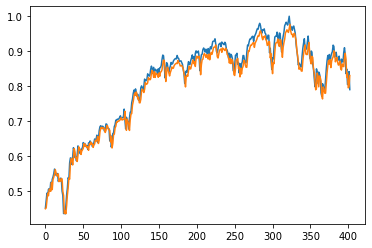

In [169]:
plt.plot(y_t)
plt.plot(pred)

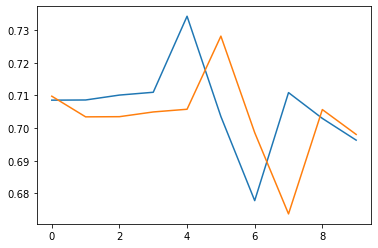

In [170]:
plt.plot(y_t[100:110])
plt.plot(pred[100:110])